# Academic Search System

- Author: [Heeah Kim](https://github.com/yellowGangneng)
- Peer Review: [Yongdam Kim](https://github.com/dancing-with-coffee), [syshin0116](https://github.com/syshin0116)
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-AcademicSearchSystem.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-AcademicSearchSystem.ipynb)

## Overview

This tutorial involves loading an open academic publication dataset called *OpenAlex* into a Graph DB named *Neo4J*.

Then, utilizing an LLM to generate <U>Cypher queries</U>, which are essentially queries for the Graph DB,
and using the data obtained from these Cypher queries to produce appropriate answers to inquiries,
we will build an *Academic Search System*.

Before we dive into the tutorial, let's understand what **GraphRAG** is and why we should use it!

**GraphRAG** refers to the RAG we already know well, but extended to include <U>not only vectors but also a **knowledge graph** in the search path.</U>

But what are the advantages of using this **GraphRAG** that we need to explore?
The reasons are as follows.

1. You can obtain more accurate and higher quality results.
    - According to Microsoft, using **GraphRAG** allowed them to obtain more relevant contexts, which led to better answers. It also made it easier to trace the grounds for those answers. 
    - Additionally, it required 26~97% fewer tokens, resulting in cost savings and scalability benefits.

2. It enhances data comprehension.
    - When looking at vectors represented by numerous numbers, it is nearly impossible for a human to conceptually and intuitively understand them.
    <br><center><img src='./assets/07-academic-search-system-01.png' alt='vector data' style="width:35%; height:35%"></center>
      <center style="color:gray">It seems impossible to understand...</center>
    <br>However, graphs are highly intuitive. They make it much easier to understand the relationships between data.
    <br><center><img src='./assets/07-academic-search-system-02.png' alt='graph data' style="width:50%; height:50%"></center>
      <center style="color:gray">It looks much clearer now.</center>
    <br>By exploring such intuitive graphs, you can gain new insights.

3. Management becomes easier in terms of tracking, explaining, and access control.
    - Using graphs, you can trace why certain data was selected or why errors occurred. This traceability can be used to explain the results.
    - Additionally, you can assign data permissions within the knowledge graph, enhancing security and privacy protection.

Knowing what **GraphRAG** is makes you want to use it even more, doesn't it?
Now, let's embark on creating an **Academic Search System** together!

### Table of Contents

- [Overview](#overview)
- [Environement Setup](#environment-setup)
- [Preliminary Task: Running Neo4j Using Docker](#preliminary-task-running-neo4j-using-docker)
- [Prepare the Data](#prepare-the-data)
- [Let's make the Academic Search System](#lets-make-the-academic-search-system)

### References

- [Create a Neo4j GraphRAG Workflow Using LangChain and LangGraph](https://neo4j.com/developer-blog/neo4j-graphrag-workflow-langchain-langgraph/)
- [The GraphRAG Manifesto: Adding Knowledge to GenAI](https://neo4j.com/blog/graphrag-manifesto/)
- [Graph-Based-Literature-Review-Tool](https://github.com/vtmike2015/Graph-Based-Literature-Review-Tool/tree/main)
- [Neo4j](https://python.langchain.com/docs/integrations/graphs/neo4j_cypher/)
- [OpenAlex](https://docs.openalex.org/)
- [GraphRAG : Neo4j DB와 LangChain 결합을 통한 질의응답 구현하기 (Kaggle CSV 데이터 적용하기)](https://uoahvu.tistory.com/entry/GraphRAG-Neo4j-DB%EC%99%80-LangChain-%EA%B2%B0%ED%95%A9%EC%9D%84-%ED%86%B5%ED%95%9C-%EC%A7%88%EC%9D%98%EC%9D%91%EB%8B%B5-%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0-Kaggle-CSV-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A0%81%EC%9A%A9%ED%95%98%EA%B8%B0)
----

<div style="color:gray">
Of course, Graph RAG does not come without its disadvantages.

1. It is quite challenging to construct.
2. It can be inefficient when dealing with unstructured data.
3. etc ...

Therefore, one must exercise caution when applying it in a production environment.

However, in this tutorial, we will focus solely on the topic of **Academic Search System**.
</div>

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [ ]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [ ]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain-neo4j",
        "langchain",
        "langchain_openai",
        "langchain_core",
        "langgraph",
        "pyalex",
    ],
    verbose=False,
    upgrade=False,
)

In [ ]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Academic Search System",
        "NEO4J_USERNAME": "",
        "NEO4J_PASSWORD": "",
        "NEO4J_URI": "",
    }
)

You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [ ]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

## Preliminary Task: Running Neo4j Using Docker

Before we get into the main tutorial, we need to perform some pre-tasks.<br>
Specifically, we need to launch the Graph DB, Neo4j, using Docker!

Since our goal is not to study Docker, we will skip the detailed explanation about Docker and share the Docker Compose code declared to launch the Neo4j container.
Please modify it according to your environment!

[Official Site : Getting started with Neo4j in Docker](https://neo4j.com/docs/operations-manual/current/docker/introduction/)

*docker-compose.yml*

```yaml
services:
  neo4j:
    container_name: neo4j-boot
    image: neo4j:5.22.0
    ports:
      - 7474:7474	# for browser console
      - 7687:7687	# for db
    volumes:
      - {your volume path}:/data
      - {your volume path}:/conf
      - {your volume path}:/plugins
      - {your volume path}:/logs # These files specify the volumes to maintain the basic Neo4j configuration and data.
      # We will convert and save the OpenAlex data into JSON format within {your volume path}/json_data,
      # and then load the data into our Neo4j database through the /import folder, which is mounted with this path.
      - {your volume path}:/import 
    environment:
      - NEO4J_dbms_security_procedures_unrestricted=apoc.*
      - NEO4J_apoc_import_file_enabled=true
      - NEO4J_apoc_export_file_enabled=true
      - NEO4J_apoc_import_file_use__neo4j__config=true
      - NEO4J_AUTH={your admin ID}/{your admin PW}
      - NEO4J_PLUGINS=["apoc"]
```

After launching the container using the above files (or in your own unique way), 

**https://localhost:7474**

if you access the local server on port 7474,
<br><center><img src='./assets/07-academic-search-system-03.png' alt='vector data' style="width:50%; height:50%"></center>
      <center style="color:gray">neo4j Browser Console</center>

Ta-da! You will be able to see the following Neo4j screen, 
<br>and you will be ready to fully enjoy the tutorial.

Shall we dive into the main content now?

## Prepare the Data

Let's prepare the Data. As mentioned earlier, we will use the **OpenAlex**, an open academic publication dataset.
OpenAlex data describes academic entities and how these entities are interconnected. The data properties provided include:
- `Works`
- `Authors`
- `Scores`
- `Institutions`
- `Topics`
- `Publishers`
- `Funders`

Among these, we will focus on handling the following data properties: `Works`, `Authors`, `Institutions`, `Topics`

### Data Structure

Before we look at the structure of the data we will create, let's briefly understand what Nodes and Relationships in a GraphDB are.

GraphDB is composed of **Nodes** and **Relationships**.

- **Node**: Refers to an individual entity. A node can have zero or more labels that define it.
- **Relationship**: Refers to the connection between a source node and a target node. Relationships always have a direction and a type.

Both nodes and relationships can have key-value pair properties.

For more detailed information about Graph properties, please refer to the [official website](https://neo4j.com/docs/getting-started/graph-database/).

Let us now explore the nodes and relationships of the data we will construct.

**Node**
- `Works`: These are academic documents such as journal articles, books, datasets, and theses.
    - `display_name`: The title of the academic document.
    - `cited_by_count`: The number of times the document has been cited.
    - `language`: The language in which the document is written.
    - `publication_year`: The year the document was published.
    - `type`: The type of the document.
    - `license`: The license under which the document is published.
    - `url`: The URL where the document is available.
<br>
<br>
- `Authors`: Information about the authors who wrote the academic documents.
  - `display_name`: The name of the author.
  - `orcid`: The author's ORCID. (ORCID is a global and unique ID for authors.)
  - `works_count`: The number of documents the author has worked on.
<br>
<br>
- `Topics`: Subjects related to the documents.
  - `display_name`: The title of the topic.
  - `description`: A description of the topic.
<br>
<br>
- `Institutions`: The institutions to which the authors were affiliated. It is included in the Authors data.
  - `display_name`: The name of the institution.
  - `ror`: The ROR (Research Organization Registry) ID of the institution.
  - `country_code`: The country where the institution is located.

**Relationship**
- `Works` <- `WROTE` - `Authors`: The relationship between an author and the documents they have written.
  - `author_position` The author's position in the authorship list (e.g., first author, second author).

- `Works` - `ASSOCIATION` -> `Topics`: The relationship between documents and topics.
  - `score` The relevance score indicating how strongly the document is related to the topic.

- `Authors` - `AFFILIATED` -> `Institutions`: The relationship between authors and the institutions with which they were affiliated.
  - `years` The years during which the author was affiliated with the institution.

<br>For more detailed information about **OpenAlex** Entities, please refer to the [official website](https://docs.openalex.org/api-entities/entities-overview).

The above structure utilizes only a small portion of the data, and you could certainly develop a more logical 
and comprehensive structure for nodes and relationships based on your own rationale.

However, for the purposes of this tutorial, we will proceed with the structure as outlined above.

In [ ]:
from pyalex import Works, Authors, Topics, Institutions
import os

json_path = "{your volume path}"  # "The local folder path to be mounted with /imports when running the Neo4j container
os.makedirs(json_path, exist_ok=True)

In [ ]:
from neo4j import GraphDatabase

# Connect with Neo4j
url = os.environ["NEO4J_URI"]
username = os.environ["NEO4J_USERNAME"]
password = os.environ["NEO4J_PASSWORD"]
driver = GraphDatabase.driver(url, auth=(username, password))

In [ ]:
import json


# Storing json data extracted from OpenAlex
# name : display_name of each entity
# entity : Works / Authors / Institutions / Topics
# page : JSON formatted data obtained through pyAlex
def make_file(name, entity, page):
    file = os.path.join(json_path, f"{name.replace(' ', '_')}_{entity}.json")
    out_file = open(file, "w")
    json.dump(page, out_file, indent=6)

    out_file.close()

    print("Now Downloading " + file)

In [ ]:
concept_id = (
    "C154945302"  # The Concept ID of Artificial Intelligence scholarly literature data
)

# Extract Works data
works_pager = (
    Works().filter(concept={"id": {concept_id}}).paginate(per_page=1, n_max=10)
)
for works_page in works_pager:
    try:
        make_file(works_page[0]["display_name"], "work", works_page[0])
        # Extract Topics data related to Works
        topics = works_page[0]["topics"]
        for topic in topics:
            try:
                topic_pager = Topics().filter(
                    display_name={"search": topic["display_name"]}
                )
                make_file(topic["display_name"], "topic", topic_pager.get()[0])
            except Exception as e:
                print(
                    "An error occurred while creating the ",
                    topic["display_name"],
                    " file. : ",
                    e,
                )

        # Extract Authors data related to Works
        for authorships in works_page[0]["authorships"]:
            try:
                author_pager = Authors().filter(
                    display_name={"search": {authorships["author"]["display_name"]}}
                )
                make_file(
                    authorships["author"]["display_name"],
                    "author",
                    author_pager.get()[0],
                )

            except Exception as e:
                print(
                    "An error occurred while creating the ",
                    authorships["author"]["display_name"],
                    " file. : ",
                    e,
                )
    except Exception as e:
        print(
            "An error occurred while creating the ",
            works_page[0]["display_name"],
            " file. : ",
            e,
        )

Let's create a graph based on the JSON file we downloaded.

In [ ]:
from glob import glob

# Retrieve the list of downloaded JSON files per node
# GSince the data to be used in the graph is accessed through the /imports folder within the container, local paths are excluded.
work_files = [i.split("\\")[-1] for i in glob(json_path + "*_work.json")]
author_files = [i.split("\\")[-1] for i in glob(json_path + "*_author.json")]
institution_files = [i.split("\\")[-1] for i in glob(json_path + "*_institution.json")]
topic_files = [i.split("\\")[-1] for i in glob(json_path + "*_topic.json")]

Now let's build a graph using Cypher. Before that, let me briefly talk about Cypher.
<br>Cypher is Neo4j’s declarative query language, allowing users to unlock the full potential of property graph databases.
<br>For more detailed information about Neo4j Cyphers, please refer to the [official website](https://neo4j.com/docs/cypher-manual/current/introduction/).

As always, a single line of code is often easier to understand than ten lines of explanation. 
<br>Let's use Cypher to insert JSON data.

Let's analyze the Cypher declared above, line by line. We will omit explanations for duplicated forms of code.

- `CALL apoc.load.json('"+ file+ "')`
  - Read the JSON files. At this time, the **APOC** module is required. In the case of the docker compose provided above, it will be automatically installed through `NEO4J_PLUGINS=['apoc']`.
<br>
<br>
- `YIELD value`
  - Returns the `value` obtained by reading the JSON file.
<br>
<br>
- `UNWIND value.authorships as authorships`
  - By separating the `authorships` list within the `value` object, each item is individually processed as `authorships` objects with an alias assigned through `as`.
<br>
<br>
- `WITH value, authorships, author, topics, field, domain`
  - Variables obtained through `YIELD` and `UNWIND` are passed to the next part of the query, making them available for subsequent operations.
<br>
<br>
- `MERGE (w:Works {id: value.id}) \
  SET w.display_name = coalesce(value.display_name, '')\
  ...`
  - The `MERGE` clause is used to match or create a node with the `Works` label that has a unique `id` property matching `value.id`. If a node with the corresponding `id` already exists, it matches that node; otherwise, it creates a new node.
  - The `SET` clause updates the `display_name` property of the `Works` node. The `coalesce` function ensures that `value.display_name` is replaced with an empty string (`''`) if it is `null`.
<br>
<br>
- `MERGE (a)-[:WROTE{author_position: authorships.author_position}]->(w)`
    - The `MERGE` clause is used to match or create a relationship between nodes `a` and `w`. Just like with nodes, if the same relationship already exists, it matches or creates it, and if it does not exist, it creates a new relationship.
    - This relationship has the `WROTE` label and includes the `author_position` property. This property is set to the value of `authorships.author_position`.

The **nodes** and **relationships** for `Authors` and `Topics` will be constructed in a similar manner, so the explanation will be omitted.

In [ ]:
for file in work_files:
    print("File being imported: " + file)
    work_node_creation = (
        "CALL apoc.load.json('"
        + file
        + "') \
        YIELD value \
        UNWIND value.authorships as authorships \
        UNWIND authorships.author as author \
        UNWIND value.topics as topics \
        UNWIND topics.field as field \
        UNWIND topics.domain as domain \
        WITH value, authorships, author, topics, field, domain \
        MERGE (w:Works {id: value.id}) \
        SET w.display_name = coalesce(value.display_name, ''), \
        w.cited_by_count = coalesce(value.cited_by_count, ''), \
        w.is_paratext = coalesce(value.is_paratext, ''), \
        w.language = coalesce(value.language, ''), \
        w.publication_year = coalesce(value.publication_year, ''), \
        w.type = coalesce(value.type, ''), \
        w.license = coalesce(value.license, ''), \
        w.url = coalesce(value.url, '')\
        MERGE (a:Authors {id: author.id})\
        SET a.display_name = coalesce(author.display_name, ''),\
        a.orcid = coalesce(author.orcid, '')\
        MERGE (a)-[:WROTE{author_position: authorships.author_position}]->(w)\
        MERGE (t:Topics {id:topics.id}) \
        SET t.display_name = coalesce(topics.display_name, '')\
        MERGE (w)-[:ASSOCIATION{score: topics.score}]->(t)"
    )
    driver.execute_query(work_node_creation)
    print("File - " + file + " import complete")

print("All works imported")

In [ ]:
for file in author_files:
    print("File being imported: " + file)
    author_node_creation = (
        "CALL apoc.load.json('"
        + file
        + "') \
        YIELD value \
        UNWIND value.affiliations as affiliations \
        UNWIND affiliations.institution as institution \
        UNWIND affiliations.years as years \
        WITH value, affiliations, institution, years \
        MERGE (a:Authors {id: value.id})\
        SET a.display_name = coalesce(value.display_name, ''),\
        a.orcid = coalesce(value.orcid, ''),\
        a.works_count = coalesce(value.works_count, '')\
        MERGE (i:Institutions {id:institution.id}) \
        SET i.display_name = coalesce(institution.display_name, ''), \
        i.ror = coalesce(institution.ror, ''), \
        i.country_code = coalesce(institution.country_code, '') \
        FOREACH (year IN years |\
        MERGE (a)-[:AFFILIATED{year: years}]->(i))"
    )
    driver.execute_query(author_node_creation)
    print("File - " + file + " import complete")

print("All authors imported")

In [ ]:
for file in topic_files:
    print("File being imported: " + file)
    topic_node_creation = (
        "CALL apoc.load.json('"
        + file
        + "') \
        YIELD value \
        UNWIND value.field as field \
        UNWIND value.domain as domain \
        WITH value, field, domain \
        MERGE (t:Topics {id: value.id})\
        SET t.display_name = coalesce(value.display_name, '')"
    )
    driver.execute_query(topic_node_creation)
    print("File - " + file + " import complete")

print("All topics imported")

The graph with all the data will have the following structure.

<br><center><img src='./assets/07-academic-search-system-04.png' alt='our graph' style="width:50%; height:50%"></center>
      <center style="color:gray">The graph we built!</center>

Now, let us integrate the generated graph with the LLM to build a Q&A system.

## Let's make the Academic Search System

### Using the default QA chain

First, let's make use of the default QA Chain provided by langchain.<br>
`GraphCypherQAChain` is a function that *generates Cypher queries* and *facilitates question-answering about graphs* 
<br>by having a pre-declared chain, making it convenient to use.

<br><center><img src='./assets/07-academic-search-system-05.png' alt='GraphCypherQAChain' style="width:50%; height:50%"></center>
      <center style="color:gray">source : [Langchain](https://python.langchain.com/v0.1/docs/use_cases/graph/)</center>

As can be seen from the above picture, the model operates the LLM once to generate a Cypher query, 
<br>then runs the GraphDB with the generated query, and operates the LLM once again to generate an appropriate response 
<br>to the user's query based on the executed results.

Let's implement a simple QA service using the `GraphCypherQAChain` function.

In [ ]:
from langchain_neo4j import GraphCypherQAChain, Neo4jGraph
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

In [54]:
# Declaring graphs and LLM models

graph = Neo4jGraph(
    os.environ["NEO4J_URI"], os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"]
)

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=os.environ["OPENAI_API_KEY"],
)

In [55]:
# (Optional) Declaration of Prompts for Generating Cypher Queries and for QA

CYPHER_GENERATION_TEMPLATE = """Task:Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.
Schema:
{schema}
Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.

The question is:
{question}"""
CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], template=CYPHER_GENERATION_TEMPLATE
)

In [56]:
CYPHER_QA_TEMPLATE = """You are an assistant that helps to form nice and human understandable answers.
The information part contains the provided information that you must use to construct an answer.
The provided information is authoritative, you must never doubt it or try to use your internal knowledge to correct it.
Make the answer sound as a response to the question. Do not mention that you based the result on the given information.

If the provided information is empty, say that you don't know the answer.
Information:
{context}

Question: {question}
Helpful Answer:"""
CYPHER_QA_PROMPT = PromptTemplate(
    input_variables=["context", "question"], template=CYPHER_QA_TEMPLATE
)

In [57]:
chain = GraphCypherQAChain.from_llm(
    llm,
    graph=graph,
    verbose=True,
    qa_prompt=CYPHER_QA_PROMPT,
    cypher_prompt=CYPHER_GENERATION_PROMPT,
    allow_dangerous_requests=True,
)

In [58]:
chain.invoke("Who is the author with the most publications?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (a:Authors)-[:WROTE]->(w:Works)
RETURN a.display_name, COUNT(w) AS publication_count
ORDER BY publication_count DESC
LIMIT 1

Full Context:
[{'a.display_name': 'Geoffrey E. Hinton', 'publication_count': 2}]

> Finished chain.


{'query': 'Who is the author with the most publications?',
 'result': 'The author with the most publications is Geoffrey E. Hinton, who has a total of 2 publications.'}

**However**, there is one issue with this function, 
<br>which is that it directly inserts the information from the query into the Cypher.

In other words, <U>you need to have precise information about the data to get the desired answer.</U>

In [59]:
chain.invoke("What literature is available related to CNN?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (t:Topics {display_name: 'CNN'})<-[:ASSOCIATION]-(w:Works)
RETURN w

Full Context:
[]

> Finished chain.


{'query': 'What literature is available related to CNN?',
 'result': "I'm sorry, but I don't know the answer."}

Therefore, instead of relying on the predefined QA chain, 
<br>we should create our own custom chain using **LangGraph**.

### Using the LangGraph chain we built 

Upon receiving a query, if it pertains to a node or the relationships between nodes, <br>
we plan to first extract related data by performing a semantic search using Embedding Vectors of specific properties. <br>
Then, we will construct a graph to utilize the extracted data for the query.

In [ ]:
from langchain.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage

from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from typing import Annotated
from typing_extensions import TypedDict

In [ ]:
# Define State


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
# Define Tools


@tool
def node_vector_search_tool(
    node_label: Annotated[
        str,
        "This is the node label that requires vector search (one of Works, Authors, Institutions, Topics).",
    ],
    query: Annotated[str, "User's query."],
):
    """
    Retrieve the node information most similar to the user's query.

    Input:
    - node_label: The label of the node. The types include Works, Authors, Institutions, and Topics.
      - Works: Node containing information about academic literature.
      - Authors: Node containing information about authors.
      - Institutions: Node containing information about institutions.
      - Topics: Node containing information about topics related to the literature.
    - query: The user's query.

    Output:
    - The node with the highest similarity is returned.
    """
    node_vector_index = Neo4jVector.from_existing_graph(
        embedding=OpenAIEmbeddings(openai_api_key=os.environ["OPENAI_API_KEY"]),
        url=os.environ["NEO4J_URI"],
        username=os.environ["NEO4J_USERNAME"],
        password=os.environ["NEO4J_PASSWORD"],
        index_name="name_vector",
        node_label=node_label,
        text_node_properties=(
            ["display_name"]
            if node_label != "Topics"
            else ["display_name", "description"]
        ),
        embedding_node_property="embedding_vectors",
    )

    result = node_vector_index.similarity_search(query, k=1)

    return result


@tool
def relationship_vector_search_tool(
    relationship_property: Annotated[
        str,
        "This is the relationship property that requires vector search (one of year, score, author_position).",
    ],
    query: Annotated[str, "User's query."],
):
    """
    Retrieve the relationship information most similar to the user's query.

    Input:
    - relationship_property: The property of the relationship. The types include year, score, and author_position.
      - year: Information about the relationship between Authors and Institutions, indicating the year an author was affiliated with an institution.
      - score: Information about the relationship between Works and Topics, indicating the percentage of their relevance.
      - author_position: Information about the relationship between Works and Authors, indicating the author's position (order) in the work.

    Output:
    - The relationship with the highest similarity is returned.
    """
    relationship_vector_index = Neo4jVector.from_existing_relationship_index(
        embedding=OpenAIEmbeddings(openai_api_key=os.environ["OPENAI_API_KEY"]),
        url=os.environ["NEO4J_URI"],
        username=os.environ["NEO4J_USERNAME"],
        password=os.environ["NEO4J_PASSWORD"],
        text_node_property=relationship_property,
        embedding_node_property="embedding_vectors",
    )

    result = relationship_vector_index.similarity_search(query, k=1)

    return result


tools = [node_vector_search_tool, relationship_vector_search_tool]
tool_node = ToolNode(tools)

In [ ]:
# Let's build our graph!

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a question generation agent that generates questions to fetch the optimal results from a Graph DB.\
            If the user's question is about academic literature, authors, topics, or institutions, use a Tool to calculate similarity with Nodes.\
            If the user's question is about the relevance between academic literature and topics, \
            the relationship between academic literature and authors, or the affiliation between authors and institutions, \
            use a Tool to calculate similarity with Relationships to find the related data. \
            Then, append the result of the Tool call to the user's question and output the revised question. \
            If not, pass the user's question as is.\
            Do not add any additional comments and output only the query.",
        ),
        ("user", "{messages}"),
    ]
)

assistant = assistant_prompt | llm.bind_tools(tools)


def chatbot(state: State):
    messages = state["messages"]
    response = assistant.invoke(messages)
    return {"messages": [response]}


def cypherQA(state: State):
    chain = GraphCypherQAChain.from_llm(
        llm,
        graph=graph,
        verbose=True,
        qa_prompt=CYPHER_QA_PROMPT,
        cypher_prompt=CYPHER_GENERATION_PROMPT,
        allow_dangerous_requests=True,
    )
    response = chain.invoke(state["messages"][-1].content)
    return {"messages": [response["result"]]}


def route_tools(state: State):
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return "cypherQA"
    return "tools"


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("cypherQA", cypherQA)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", route_tools, ["tools", "cypherQA"])
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("cypherQA", END)

app = graph_builder.compile()

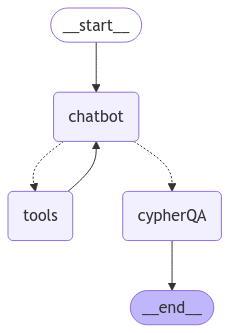

In [79]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# Visualize the compiled StateGraph as a Mermaid diagram
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
# Let's actually operate the graph.

user_query = "CNN Works"

events = app.stream(
    {"messages": [HumanMessage(content=user_query)]}, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

CNN Works
================================== Ai Message ==================================
Tool Calls:
  node_vector_search_tool (call_lslW14cJ6XyY26udbv42MGqX)
 Call ID: call_lslW14cJ6XyY26udbv42MGqX
  Args:
    node_label: Works
    query: CNN Works
================================= Tool Message =================================
Name: node_vector_search_tool

[Document(metadata={'title': 'ImageNet Classification with Deep Convolutional Neural Networks', 'cited_by_count': 67974, 'publication_year': 2012, 'language': 'en', 'license': '', 'is_paratext': False, 'type': 'article', 'url': ''}, page_content='\ndisplay_name: ImageNet Classification with Deep Convolutional Neural Networks')]
================================== Ai Message ==================================

What are the details of the work titled "ImageNet Classification with Deep Convolutional Neural Networks"?


> Entering new GraphCypherQAChain

By acquiring the data most similar to the user's query through semantic search and adjusting the query to fit the acquired data, we were able to obtain the desired answer.

In other words, even without knowing the precise terminology, we have built a QA System that allows us to obtain the desired answers!

This concludes the tutorial for the **Academic Search System**. Thank you for your hard work this time as well!